In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv('data/train.csv')

In [3]:
# make the id the index and drop the id column
df.index = df['id']
df = df.drop(columns='id')

# Lil Exploration

In [4]:
print(f'Rows: {df.shape[0]}')
print(f'Columns: {df.shape[1]}')

Rows: 7471
Columns: 21


In [5]:
df.head(5)

,Decision,Host_response_time,Host_is_superhost,Host_has_profile_pic,Host_identity_verified,Neighbourhood,Property_type,Room_type,Accommodates,Bathrooms_text,...,Beds,Essentials,Cooking,Balcony,Parking,Price,Number_of_reviews,Review_scores_rating,Instant_bookable,Month
id,,,,,,,,,,,,,,,,,,,,,
1,1,within an hour,t,t,t,28806,Entire cabin,Entire home/apt,6,1 bath,...,3.0,5,5,1,1,$164.00,90,4.93,t,August
2,1,within an hour,t,t,t,28804,Entire house,Entire home/apt,4,1 bath,...,1.0,5,4,1,1,$101.00,522,4.69,t,June
3,0,within a few hours,t,t,t,28806,Private room in bungalow,Private room,1,1 private bath,...,1.0,5,3,1,1,$32.00,35,4.83,f,June
4,1,within an hour,t,t,t,28803,Entire condominium (condo),Entire home/apt,8,2 baths,...,5.0,5,5,0,1,$381.00,11,5.00,t,September
5,0,within an hour,t,t,t,28805,Entire house,Entire home/apt,6,2 baths,...,4.0,5,5,1,1,$238.00,63,4.70,f,July


In [6]:
print('Columns Data Types:')
print('Counts:')
print(df.dtypes.value_counts())
print('\nColumns:')
print(df.dtypes)
print()
print(df.drop(columns=['Decision']).dtypes.value_counts())

Columns Data Types:
Counts:
object     10
int64       8
float64     3
dtype: int64

Columns:
Decision                    int64
Host_response_time         object
Host_is_superhost          object
Host_has_profile_pic       object
Host_identity_verified     object
Neighbourhood               int64
Property_type              object
Room_type                  object
Accommodates                int64
Bathrooms_text             object
Bedrooms                  float64
Beds                      float64
Essentials                  int64
Cooking                     int64
Balcony                     int64
Parking                     int64
Price                      object
Number_of_reviews           int64
Review_scores_rating      float64
Instant_bookable           object
Month                      object
dtype: object

object     10
int64       7
float64     3
dtype: int64


In [7]:
# check for any columns with tons of NaNs
df.isnull().sum() / df.shape[0]

Decision                  0.000000
Host_response_time        0.114844
Host_is_superhost         0.012850
Host_has_profile_pic      0.012850
Host_identity_verified    0.012850
Neighbourhood             0.000000
Property_type             0.000000
Room_type                 0.000000
Accommodates              0.000000
Bathrooms_text            0.000000
Bedrooms                  0.078303
Beds                      0.001740
Essentials                0.000000
Cooking                   0.000000
Balcony                   0.000000
Parking                   0.000000
Price                     0.000000
Number_of_reviews         0.000000
Review_scores_rating      0.052871
Instant_bookable          0.000000
Month                     0.000000
dtype: float64

Looks like Host_response_time, Bedrooms (strange...), and Review_scores_rating have a decent amount of NaNs. It's not enought to take them out at this point, but we'll keep an eye on it

In [8]:
# Check for empty rows
for i in range(10):
    print(f'# of rows with > {i} Null values: {df[df.isnull().sum(axis=1) > i].shape[0]}')

# of rows with > 0 Null values: 1605
# of rows with > 1 Null values: 193
# of rows with > 2 Null values: 96
# of rows with > 3 Null values: 96
# of rows with > 4 Null values: 93
# of rows with > 5 Null values: 56
# of rows with > 6 Null values: 0
# of rows with > 7 Null values: 0
# of rows with > 8 Null values: 0
# of rows with > 9 Null values: 0


There doesn't appear to be any rows that have a significant amount of Null values. So let's keep em all

Decision


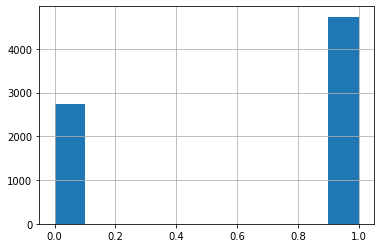

Neighbourhood


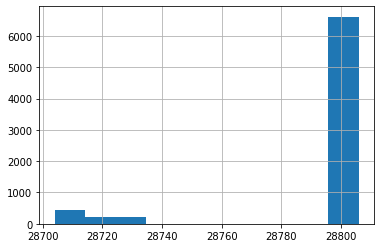

Accommodates


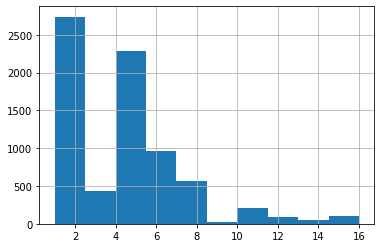

Bedrooms


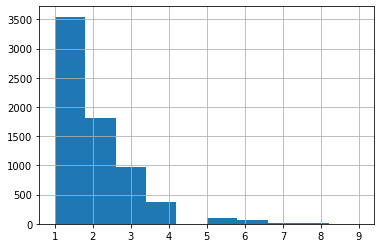

Beds


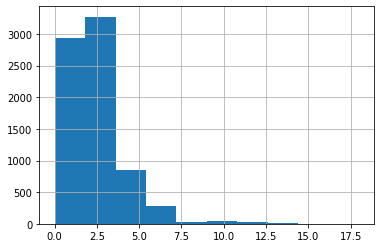

Essentials


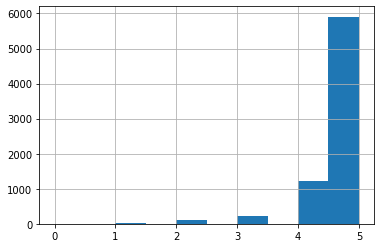

Cooking


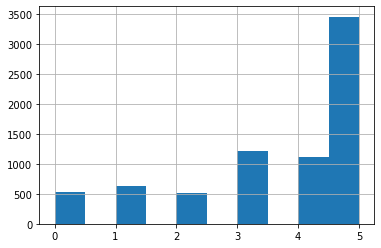

Balcony


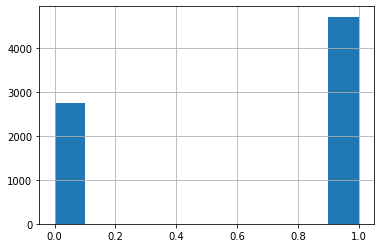

Parking


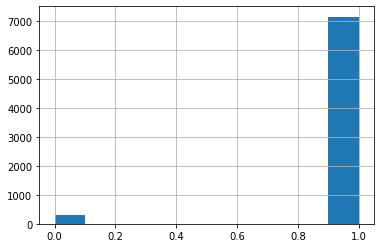

Number_of_reviews


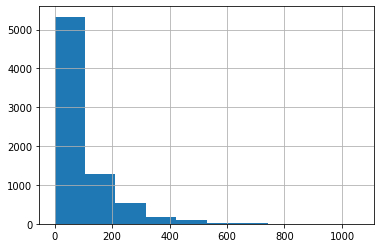

Review_scores_rating


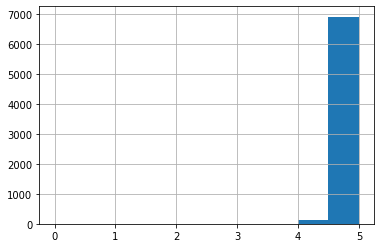

In [9]:
# Take a look at the numerical cols histograms
for c,t in df.dtypes.iteritems():
    if t != 'object':
        print(c)
        df[c].hist()
        plt.savefig(f'figs/{c}.png')
        plt.show()

All the numerical columns look pretty clean - no crazy outliers which us nice. We will want to change the neighborhood int value into a categorical value - as the magnitude of the zip code is meaningless so this should be treated as a category

In [10]:
# check for outliers in number of reviews or review rating
stds_to_outlier = 3
for c in ['Number_of_reviews', 'Review_scores_rating']:
    print(c)
    mean = df[c].mean()
    std = df[c].std()
    print(df[(df[c] > mean + (3*std)) | (df[c] < mean - (3*std))].shape[0])

Number_of_reviews
153
Review_scores_rating
37


In [11]:
# check for the number of unique values for the features of type 'object'
df[[c for c,t in df.dtypes.items() if t == 'object']].nunique()

Host_response_time          4
Host_is_superhost           2
Host_has_profile_pic        2
Host_identity_verified      2
Property_type              55
Room_type                   4
Bathrooms_text             23
Price                     598
Instant_bookable            2
Month                       4
dtype: int64

Looks like there are a lot of unique Property_type and Beathrooms_text. We may need to figure out if we can clump some of these together to get better results.

# Cleaning Time

Since there are only 10 *object* type columns, the safest and most effective way to approach this is to just look at each column individually to determine how to clean it up.

In [12]:
#We'll save all our mapping in a big dictionary
value_maps = {}

# we'll also save any values we want to join for given columns in a dictionary
value_joins = {}

# We'll save all the cols we end up dropping in a list
drop_cols = []

# Finally, we'll save any fillna values in this dict
nan_fills = {}

In [13]:
# couple helper functions
def quick_summary(col):
    """Takes column name as argument and prints a couple of important statistics"""
    print('Value Counts:')
    print(df[col].value_counts())
    print(f"\n# NaNs: {df[col].isna().sum()}")
    
def merge_values(df, col, combine):
    """merges two values together in a df
    
    args: 
        df : df to merge values in
        col : string value indicating the column to merge values in
        combine : list of lists. will combine each of the values in each sublist into one value
        
    returns:
        df with values merged
    """
    for c in combine:
        df[col] = df[col].replace({v:'/'.join([str(k) for k in c]) for v in c})
    return df
    
def create_map(df, col, combine=None, order=None):
    """creates a map to change object values to unique integer values.
    
    args: 
        df : df to create map for
        col : string value indicating the column to create map for
        combine : None or list of lists. If list of lists, will combine each of the values in each sublist into one value
        order : list of explicit order to put the values if desired. if None, will just do alphabetical order of .unique() values
    returns:
        dictionary of object:int mapping
    """
    if combine:
        merge_values(df, col, combine)
    if order:
        return {v:k for k,v in enumerate(order)}
    return {v:k for k,v in enumerate(df[col].unique())}


In [14]:
obj_cols = [c for c,t in df.dtypes.iteritems() if t == 'object']
obj_cols

['Host_response_time',
 'Host_is_superhost',
 'Host_has_profile_pic',
 'Host_identity_verified',
 'Property_type',
 'Room_type',
 'Bathrooms_text',
 'Price',
 'Instant_bookable',
 'Month']

In [15]:
# Host_response_time
col = 'Host_response_time'
quick_summary(col)

Value Counts:
within an hour        5818
within a few hours     509
within a day           262
a few days or more      24
Name: Host_response_time, dtype: int64

# NaNs: 858


No need to combine values here. Let's just treat NaNs as their own value. So just create map and use to replace the objects with int values.

In [16]:
value_joins[col] = [['a few days or more', None]]
value_maps[col] = create_map(df, col, value_joins[col], order=['within an hour', 'within a few hours', 'within a day', 'a few days or more/None'])
df[col] = df[col].replace(value_maps[col])

In [17]:
# Host_is_superhost
col = 'Host_is_superhost'
quick_summary(col)

Value Counts:
t    5451
f    1924
Name: Host_is_superhost, dtype: int64

# NaNs: 96


I am going to assume that a NaN value is more likely to **not** be a superhost - so let's combine these two values.

In [18]:
value_joins[col] = [['f', None]]
value_maps[col] = create_map(df, col, value_joins[col], order=['f/None', 't'])
df[col] = df[col].replace(value_maps[col])

In [19]:
# 'Host_has_profile_pic'
col = 'Host_has_profile_pic'
quick_summary(col)

Value Counts:
t    7362
f      13
Name: Host_has_profile_pic, dtype: int64

# NaNs: 96


Once again, I am going to assume that a NaN value is more likely to **not** have a profile pic - so let's combine these two values.

In [20]:
value_joins[col] = [['f', None]]
value_maps[col] = create_map(df, col, value_joins[col], order=['f/None', 't'])
# value_maps[col] = create_map(df, col, order=['f', None, 't'])
df[col] = df[col].replace(value_maps[col])

In [21]:
# 'Host_identity_verified'
col = 'Host_identity_verified'
quick_summary(col)

Value Counts:
t    5682
f    1693
Name: Host_identity_verified, dtype: int64

# NaNs: 96


Once again, I am going to assume that a NaN value is more likely to **not** have their identity verified - so let's combine these two values.

In [22]:
value_joins[col] = [['f', None]]
value_maps[col] = create_map(df, col, value_joins[col], order=['f/None', 't'])
# value_maps[col] = create_map(df, col, order=['f', None, 't'])
df[col] = df[col].replace(value_maps[col])

In [23]:
# 'Property_type'
col = 'Property_type'
quick_summary(col)

Value Counts:
Entire house                           1132
Entire guest suite                     1118
Entire residential home                1082
Entire apartment                        550
Entire rental unit                      536
Private room in house                   355
Private room in residential home        331
Entire cottage                          269
Entire guesthouse                       246
Entire cabin                            216
Entire condominium                      192
Entire condominium (condo)              192
Entire bungalow                         187
Private room in bed and breakfast       146
Entire townhouse                        137
Tiny house                               98
Entire loft                              98
Private room in bungalow                 77
Private room in guest suite              70
Room in bed and breakfast                56
Campsite                                 34
Room in boutique hotel                   34
Entire chalet     

Uff okay now it gets interesting. Imma start by seeing what it looks like to just clump all the room and entire places together.

In [24]:
room = [c for c in df[col].unique() if 'room' in c.lower()]
entire = [c for c in df[col].unique() if 'entire' in c.lower()]
print(f'Num private types: {len(room)}')
print(f'Num entire types: {len(entire)}')

Num private types: 28
Num entire types: 16


In [25]:
# remaining things we have to deal with...
[c for c in df[col].unique() if c not in room+entire]

['Tiny house',
 'Casa particular (Cuba)',
 'Campsite',
 'Camper/RV',
 'Farm stay',
 'Yurt',
 'Bus',
 'Treehouse',
 'Tent',
 'Shipping container',
 'Casa particular']

In [26]:
df[df[col].isin([c for c in df[col].unique() if c not in room+entire])][col].value_counts()

Tiny house                98
Campsite                  34
Camper/RV                 32
Farm stay                 16
Bus                       12
Treehouse                 12
Yurt                      11
Tent                       8
Shipping container         4
Casa particular (Cuba)     4
Casa particular            2
Name: Property_type, dtype: int64

Most of these could definitely be classified as an entire place as well. While the campsite is a bit iffy, the fact that there are only 34 makes it less vital. So for now lets classify all these as entire places as well.

In [27]:
entire += [c for c in df[col].unique() if c not in room+entire]
print(f'Num private types: {len(room)}')
print(f'Num entire types: {len(entire)}')

Num private types: 28
Num entire types: 27


In [28]:
value_joins[col] = [room, entire]
value_maps[col] = create_map(df, col, value_joins[col])
df[col] = df[col].replace(value_maps[col])

In [29]:
# 'Room_type'
col = 'Room_type'
quick_summary(col)

Value Counts:
Entire home/apt    6232
Private room       1149
Hotel room           66
Shared room          24
Name: Room_type, dtype: int64

# NaNs: 0


Lets combine all the room types

In [30]:
value_joins[col] = [[c for c in df[col].unique() if 'room' in c.lower()]]
value_maps[col] = create_map(df, col, value_joins[col])
df[col] = df[col].replace(value_maps[col])

Now I realize that I may have just created two identical cols in room type and property type...

In [31]:
df[['Room_type', 'Property_type']].corr()

,Room_type,Property_type
Room_type,1.0,1.0
Property_type,1.0,1.0


Yup, these are now the exact same... So let's just drop Property_type (since it is more complex) and move on

In [32]:
drop_cols.append('Property_type')
df = df.drop(columns=['Property_type'])
value_maps.pop('Property_type')
value_joins.pop('Property_type')

[['Private room in bungalow',
  'Private room in residential home',
  'Room in boutique hotel',
  'Private room in guest suite',
  'Private room in bed and breakfast',
  'Private room in house',
  'Private room',
  'Private room in camper/rv',
  'Room in bed and breakfast',
  'Shared room in hostel',
  'Private room in treehouse',
  'Private room in rental unit',
  'Private room in cottage',
  'Private room in farm stay',
  'Private room in hostel',
  'Private room in apartment',
  'Private room in condominium (condo)',
  'Private room in townhouse',
  'Private room in castle',
  'Private room in cabin',
  'Shared room in apartment',
  'Private room in hut',
  'Room in hotel',
  'Shared room in rental unit',
  'Shared room in residential home',
  'Private room in guesthouse',
  'Private room in condominium',
  'Shared room in house'],
 ['Entire cabin',
  'Entire house',
  'Entire condominium (condo)',
  'Entire residential home',
  'Entire rental unit',
  'Entire bungalow',
  'Entire g

In [33]:
# 'Bathrooms_text'
col = 'Bathrooms_text'
quick_summary(col)

Value Counts:
1 bath               4019
2 baths              1391
1 private bath        665
3 baths               281
1.5 baths             278
2.5 baths             252
1 shared bath         251
3.5 baths              84
4 baths                72
4.5 baths              28
2 shared baths         28
1.5 shared baths       25
2.5 shared baths       20
5 baths                20
0 baths                12
6 baths                12
Half-bath               7
6.5 baths               6
7 baths                 4
Private half-bath       4
0 shared baths          4
9 baths                 4
5.5 baths               4
Name: Bathrooms_text, dtype: int64

# NaNs: 0


Let's make this into a float value of the # of bathrooms. If we want to create bins we can do that later. For this one lets make our own way to convert with as the helper function we made isn't as helpful here.

In [34]:
df[col] = df[col].apply(lambda x : float(x.split()[0]) if len(x.split()[0]) < 4 else 0.5)

In [35]:
# 'Price'
col = 'Price'
quick_summary(col)

Value Counts:
$150.00     115
$95.00      103
$125.00      99
$100.00      92
$80.00       88
           ... 
$455.00       1
$503.00       1
$744.00       1
$315.00       1
$372.00       1
Name: Price, Length: 598, dtype: int64

# NaNs: 0


This just needs to be converted to a float value

In [36]:
df[col] = df[col].apply(lambda x : float(x.replace('$', '').replace(',','')))

In [37]:
# 'Instant_bookable'
col = 'Instant_bookable'
quick_summary(col)

Value Counts:
t    4389
f    3082
Name: Instant_bookable, dtype: int64

# NaNs: 0


In [38]:
value_maps[col] = create_map(df, col, order=['f', 't'])
df[col] = df[col].replace(value_maps[col])

In [39]:
# 'Month'
col = 'Month'
quick_summary(col)

Value Counts:
June         1929
July         1897
August       1851
September    1794
Name: Month, dtype: int64

# NaNs: 0


In [40]:
value_maps[col] = create_map(df, col, order=['June', 'July', 'August', 'September'])
df[col] = df[col].replace(value_maps[col])

Now that we've converted all the object type columns to integer values, lets deal with ath neighborhood column.

In [41]:
# 'Neighbourhood'
col = 'Neighbourhood'
quick_summary(col)

Value Counts:
28806    2033
28801    1777
28803    1009
28804     940
28805     856
28704     429
28715     224
28732     203
Name: Neighbourhood, dtype: int64

# NaNs: 0


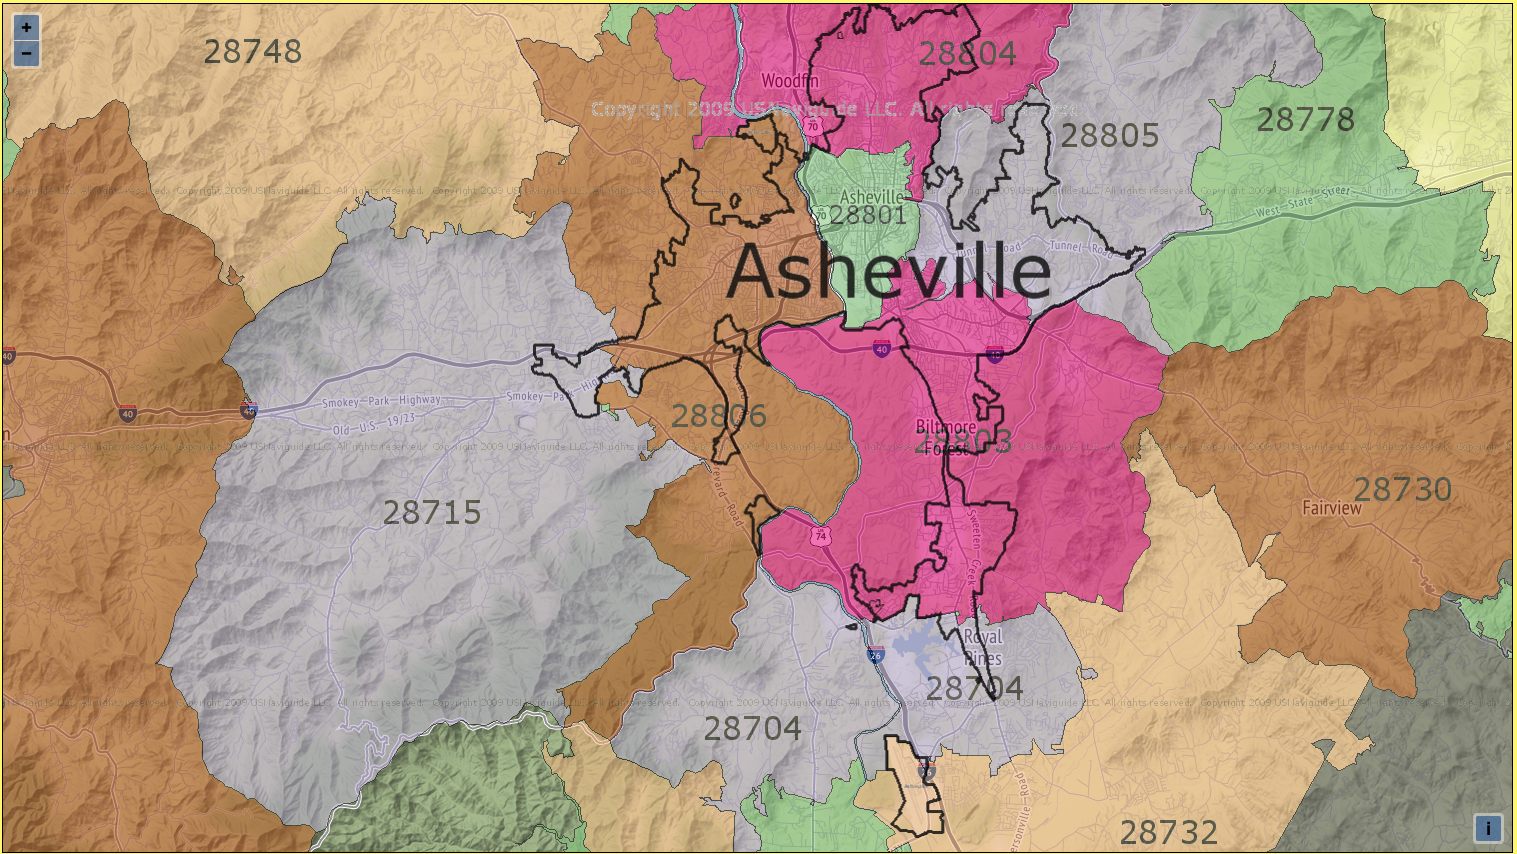

Looking at the image above (retrieved from https://zipmap.net/North_Carolina/Buncombe_County/Asheville.htm) you can see that all of the 288* zip codes are closer to downtown, whereas the 287* zip codes are bit farther out. Because of this I am going to combine the 287* zip codes to make less categories and hopefully help improve the model.

**Edit: The above did not help, I kept the code and commented it out - but I actually had better results when I just kept each neighborhood seperate**

In [42]:
# value_joins[col] = [[c for c in df[col].unique() if '287' in str(c)]]
# value_maps[col] = create_map(df, col, value_joins[col])
value_maps[col] = create_map(df, col)
df[col] = df[col].replace(value_maps[col])

In [43]:
# verify that all cols are now int or float dtypes
df.dtypes

Decision                    int64
Host_response_time          int64
Host_is_superhost           int64
Host_has_profile_pic        int64
Host_identity_verified      int64
Neighbourhood               int64
Room_type                   int64
Accommodates                int64
Bathrooms_text            float64
Bedrooms                  float64
Beds                      float64
Essentials                  int64
Cooking                     int64
Balcony                     int64
Parking                     int64
Price                     float64
Number_of_reviews           int64
Review_scores_rating      float64
Instant_bookable            int64
Month                       int64
dtype: object

In [44]:
# Take a last look at the NaNs now
df.isna().sum()

Decision                    0
Host_response_time          0
Host_is_superhost           0
Host_has_profile_pic        0
Host_identity_verified      0
Neighbourhood               0
Room_type                   0
Accommodates                0
Bathrooms_text              0
Bedrooms                  585
Beds                       13
Essentials                  0
Cooking                     0
Balcony                     0
Parking                     0
Price                       0
Number_of_reviews           0
Review_scores_rating      395
Instant_bookable            0
Month                       0
dtype: int64

In [45]:
# Lets take a look at the bedrooms NaN issue
print(f'Percent of data with NaN value for "Bedrooms": {(df[df["Bedrooms"].isna()].shape[0] / df.shape[0])*100}%')

Percent of data with NaN value for "Bedrooms": 7.8302770713425245%


In [46]:
# Check for correlation between this variable and other vars
df.corr()['Bedrooms']

Decision                  0.026453
Host_response_time       -0.076200
Host_is_superhost        -0.019829
Host_has_profile_pic      0.064941
Host_identity_verified    0.022895
Neighbourhood            -0.040649
Room_type                -0.299496
Accommodates              0.886217
Bathrooms_text            0.814742
Bedrooms                  1.000000
Beds                      0.853239
Essentials                0.009855
Cooking                   0.261557
Balcony                   0.119639
Parking                   0.072164
Price                     0.553002
Number_of_reviews        -0.207405
Review_scores_rating      0.003909
Instant_bookable          0.062315
Month                    -0.000042
Name: Bedrooms, dtype: float64

Given how strongly Bedrooms correlates with Accomodates and Beds, it's probably just better to drop this var rather than drop all these samples and/or try to figure out some way to convert to NaNs to some value

In [47]:
# drop bedrooms col
drop_cols.append('Bedrooms')
df = df.drop(columns=['Bedrooms'])

In [48]:
# Lets take a look at the beds NaN issue
print(f'Percent of data with NaN value for "Beds": {(df[df["Beds"].isna()].shape[0] / df.shape[0])*100}%')

Percent of data with NaN value for "Beds": 0.174006157140945%


In [49]:
# Lets see if we can figure out what value best fits the NaN for beds
df[df["Beds"].isna()].groupby('Accommodates')['Decision'].count()

Accommodates
2    13
Name: Decision, dtype: int64

In [50]:
df[df['Accommodates'] == 2].groupby('Beds')['Decision'].count() / df[df['Accommodates'] == 2].shape[0]

Beds
0.0    0.033408
1.0    0.834835
2.0    0.116366
3.0    0.009009
4.0    0.001502
Name: Decision, dtype: float64

Basically what I did here was realize that all of the samples that had Beds == NaN had Acccommodates == 2. From here, I observed that the vast majority of listings where Accommodates == 2 has Beds == 1. So I will make all these Beds == NaN values to Beds == 1.

In [51]:
nan_fills['Beds'] = 1
df['Beds'] = df['Beds'].fillna(1)

In [52]:
# Lets take a look at the Review_scores_rating NaN issue
print(f'Percent of data with NaN value for "Review_scores_rating": {(df[df["Review_scores_rating"].isna()].shape[0] / df.shape[0])*100}%')

Percent of data with NaN value for "Review_scores_rating": 5.287110159282559%


In [53]:
# check for strong correlation
df.corr()['Review_scores_rating']

Decision                 -0.029274
Host_response_time        0.014423
Host_is_superhost         0.159173
Host_has_profile_pic     -0.015812
Host_identity_verified   -0.012177
Neighbourhood            -0.033053
Room_type                -0.037979
Accommodates              0.008326
Bathrooms_text            0.013483
Beds                      0.018281
Essentials                0.095524
Cooking                   0.039945
Balcony                   0.093466
Parking                  -0.002139
Price                    -0.081034
Number_of_reviews         0.032602
Review_scores_rating      1.000000
Instant_bookable         -0.046536
Month                    -0.009758
Name: Review_scores_rating, dtype: float64

Nothing seems to have a very high correlation with the review score. But let's check the number of reviews for all of these NaN ratings.

In [54]:
df[df["Review_scores_rating"].isna()].groupby('Number_of_reviews')['Decision'].count()

Number_of_reviews
0    395
Name: Decision, dtype: int64

So it looks like all of these NaN review scores are just because there aren't any reviews yet. That being said, I'd be curious how the review score tends to change with the number of reviews.

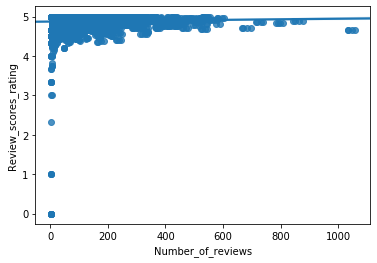

In [55]:
sns.regplot(df['Number_of_reviews'],df['Review_scores_rating'])

Given that there is really no correlation with the rating given the number of reviews, it's a rather safe bet to just assign all of these samples with 0 reviews to have the avg rating

In [56]:
nan_fills['Review_scores_rating'] = df['Review_scores_rating'].mean()
df['Review_scores_rating'] = df['Review_scores_rating'].fillna(df['Review_scores_rating'].mean())

Decision


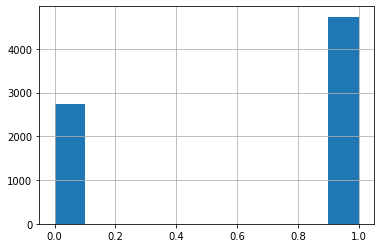

Host_response_time


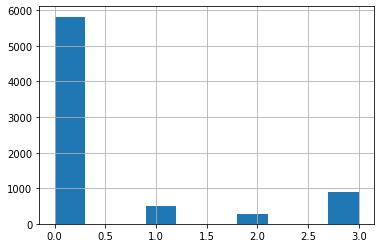

Host_is_superhost


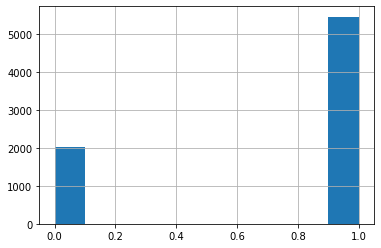

Host_has_profile_pic


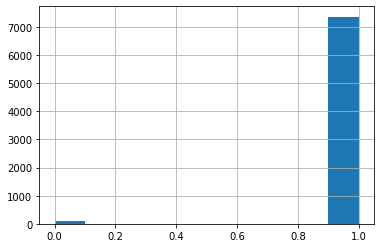

Host_identity_verified


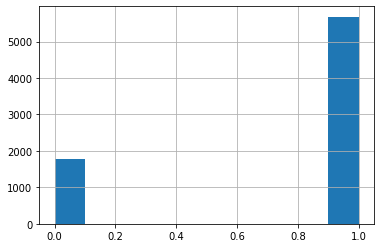

Neighbourhood


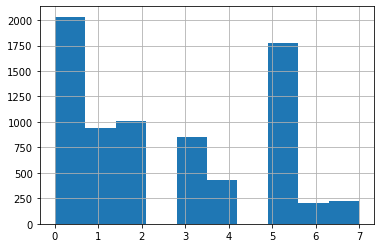

Room_type


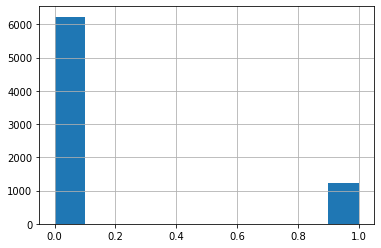

Accommodates


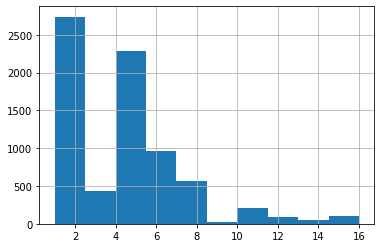

Bathrooms_text


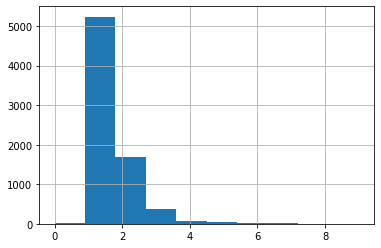

Beds


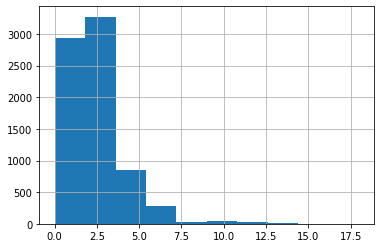

Essentials


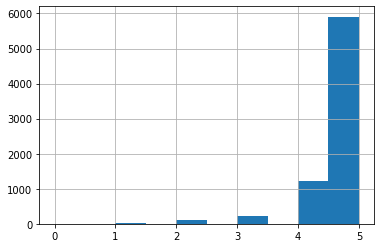

Cooking


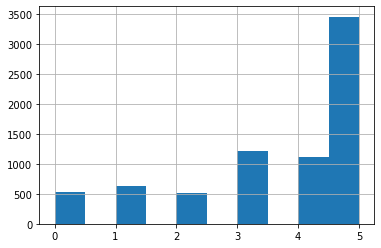

Balcony


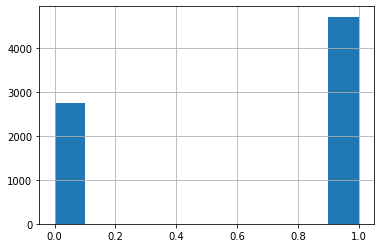

Parking


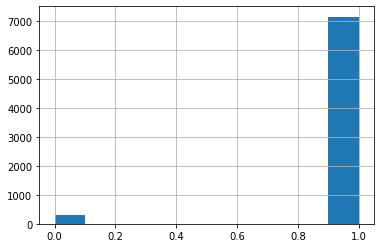

Price


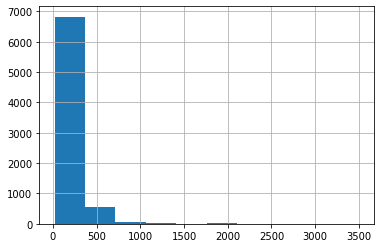

Number_of_reviews


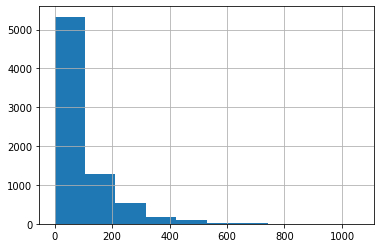

Review_scores_rating


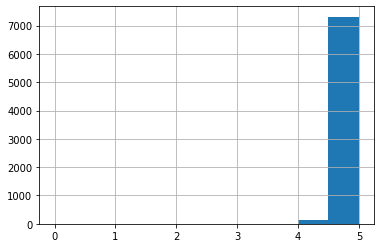

Instant_bookable


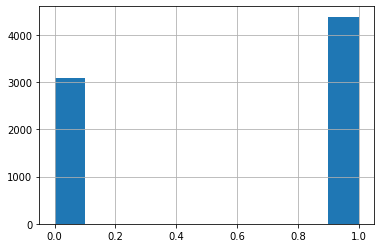

Month


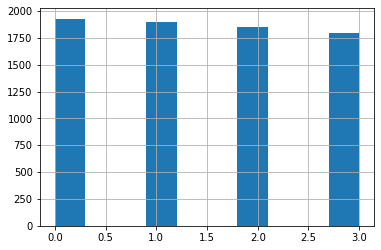

In [57]:
# Now that everything is a numeric value, lets plot some histograms again
for c in df.columns:
    print(c)
    df[c].hist()
    if c in obj_cols:
        plt.savefig(f'figs/{c}.png')
    plt.show()

# Create CleanUp and Encoder Classes

To make it easier to work with, we are going to use sklearn's Pipelines

First we need to make a class that executes all the data cleaning we just did.

In [58]:
# cols we will one hot encode
encode_cols = ['Room_type', 'Month', 'Neighbourhood']

# remove cols that will be one hot encoded 
value_maps = {k:v for k,v in value_maps.items() if k not in encode_cols}

In [59]:
class CleanUp:
    def __init__(self, mappings=value_maps, joins=value_joins, drops=drop_cols, nan_fills=nan_fills):
        self.mappings = mappings
        self.joins = joins
        self.drops = drops
        self.nan_fills = nan_fills
        
    def fit(self, X, y):
        return self
        
    def transform(self, x):
        x = x.copy(deep=True)
        x.index = x['id']
        x = x.drop(columns=['id'] + self.drops)
        for col,j in self.joins.items():
            x = merge_values(x, col, j)
        for col,m in self.mappings.items():
            x[col] = x[col].replace(m)
        x['Bathrooms_text'] = x['Bathrooms_text'].apply(lambda x : float(x.split()[0]) if len(x.split()[0]) < 4 else 0.5)
        x['Price'] = x['Price'].apply(lambda x : float(x.replace('$', '').replace(',','')))
        for col,f in self.nan_fills.items():
            x[col] = x[col].fillna(f)
        return x
        

In [60]:
class OneHotEncode:
    def __init__(self, cols_to_encode=encode_cols, unknowns='ignore'):
        self.cols_to_encode = cols_to_encode
        self.encoder = OneHotEncoder(sparse=False, handle_unknown=unknowns)
        
    def fit(self, X, y):
        self.encoder.fit(X[self.cols_to_encode].astype(str).to_numpy())
        return self
        
    def transform(self, X):
        X = X.copy(deep=True)
        encodings = self.encoder.transform(X[self.cols_to_encode].astype(str).to_numpy())
        return np.hstack((X.drop(columns=self.cols_to_encode).to_numpy(), encodings))

# Model Away

In [61]:
train = pd.read_csv('data/train.csv')
X_train = train.drop(columns=['Decision'])
y_train = train['Decision'].to_numpy()

test = pd.read_csv('data/test.csv')
X_test = test

In [62]:
def save_preds(model, file_name):
    """Helper funtion to make predictions on test set and save to file in format that can be submitted to Kaggle."""
    preds = pd.DataFrame(model.predict(X_test))
    preds = preds.reset_index(drop=False)
    preds = preds.rename(columns={'index': 'id', 0:'Decision'})
    preds['id'] +=1
    preds.to_csv(f'preds/{file_name}.csv', index=False)    

## Random Forest 

In [63]:
# metrics to compute in the grid search cv
metrics = ['accuracy', 'f1', 'roc_auc']

# metric value to use when choosing which model parameters are the best. 
# These parameters are then used to refit the model on whole training set.
refit_metric = 'accuracy'

# number of cross validation folds
n_folds = 10

In [64]:
forest_params_grid = {
    'forest__criterion': ['gini', 'entropy'],
    'forest__min_samples_split' : [2,4,8,10,12,14],
    'forest__max_features': ['auto', 0.5],
    'forest__max_samples': [0.5, 0.75, 0.9, 1-1e-8]
}

forest_pipe = Pipeline(steps=[("clean_up", CleanUp()), ("one_hot", OneHotEncode()), ("forest", RandomForestClassifier())])


In [65]:
forest = GridSearchCV(forest_pipe, forest_params_grid, scoring=metrics, refit=refit_metric, cv=n_folds, return_train_score=True)
forest.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('clean_up',
                                        <__main__.CleanUp object at 0x7fa53b7f2910>),
                                       ('one_hot',
                                        <__main__.OneHotEncode object at 0x7fa53b53a3d0>),
                                       ('forest', RandomForestClassifier())]),
             param_grid={'forest__criterion': ['gini', 'entropy'],
                         'forest__max_features': ['auto', 0.5],
                         'forest__max_samples': [0.5, 0.75, 0.9, 0.99999999],
                         'forest__min_samples_split': [2, 4, 8, 10, 12, 14]},
             refit='accuracy', return_train_score=True,
             scoring=['accuracy', 'f1', 'roc_auc'])

In [66]:
forest_results = pd.DataFrame(forest.cv_results_)

In [67]:
save_preds(forest, 'random_forest')

## XGBoost 

In [68]:
xg_params_grid = {
    'xg__n_estimators': [10, 25, 50, 100, 200],
    'xg__max_depth': [5, 10, 15, 20, 25, 30],
    'xg__learning_rate' : [0.1, 1],
    'xg__reg_lambda': [0.5,1,2]
}

xg_pipe = Pipeline(steps=[("clean_up", CleanUp()), ("one_hot", OneHotEncode()), ("xg", XGBClassifier())])


In [69]:
xg = GridSearchCV(xg_pipe, xg_params_grid, scoring=metrics, refit=refit_metric, cv=n_folds, return_train_score=True)
xg.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('clean_up',
                                        <__main__.CleanUp object at 0x7fa53be16890>),
                                       ('one_hot',
                                        <__main__.OneHotEncode object at 0x7fa53c16efd0>),
                                       ('xg', XGBClassifier())]),
             param_grid={'xg__learning_rate': [0.1, 1],
                         'xg__max_depth': [5, 10, 15, 20, 25, 30],
                         'xg__n_estimators': [10, 25, 50, 100, 200],
                         'xg__reg_lambda': [0.5, 1, 2]},
             refit='accuracy', return_train_score=True,
             scoring=['accuracy', 'f1', 'roc_auc'])

In [70]:
xg_results = pd.DataFrame(xg.cv_results_)

In [71]:
save_preds(xg, 'xgboost')

## K-Nearest Neighbors Classifier 

In [72]:
knn_params_grid = {
    'knn__n_neighbors': [3,5,7,9,11,13,15],
    'knn__weights': ['uniform', 'distance']
}

knn_pipe = Pipeline(steps=[("clean_up", CleanUp()), ("one_hot", OneHotEncode()), ("scaler", RobustScaler()), ("knn", KNeighborsClassifier())])


In [73]:
knn = GridSearchCV(knn_pipe, knn_params_grid, scoring=metrics, refit=refit_metric, cv=n_folds, return_train_score=True)
knn.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('clean_up',
                                        <__main__.CleanUp object at 0x7fa53c40bf50>),
                                       ('one_hot',
                                        <__main__.OneHotEncode object at 0x7fa53c40be10>),
                                       ('scaler', RobustScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [3, 5, 7, 9, 11, 13, 15],
                         'knn__weights': ['uniform', 'distance']},
             refit='accuracy', return_train_score=True,
             scoring=['accuracy', 'f1', 'roc_auc'])

In [74]:
knn_results = pd.DataFrame(knn.cv_results_)

In [75]:
save_preds(knn, 'knn')

# Explore Results

In [76]:
# put these results into a dict to we can iterate over them more easily
results = {'forest' : forest_results, 'xg' : xg_results, 'knn' : knn_results}

In [77]:
forest_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_forest__criterion', 'param_forest__max_features',
       'param_forest__max_samples', 'param_forest__min_samples_split',
       'params', 'split0_test_accuracy', 'split1_test_accuracy',
       'split2_test_accuracy', 'split3_test_accuracy', 'split4_test_accuracy',
       'split5_test_accuracy', 'split6_test_accuracy', 'split7_test_accuracy',
       'split8_test_accuracy', 'split9_test_accuracy', 'mean_test_accuracy',
       'std_test_accuracy', 'rank_test_accuracy', 'split0_train_accuracy',
       'split1_train_accuracy', 'split2_train_accuracy',
       'split3_train_accuracy', 'split4_train_accuracy',
       'split5_train_accuracy', 'split6_train_accuracy',
       'split7_train_accuracy', 'split8_train_accuracy',
       'split9_train_accuracy', 'mean_train_accuracy', 'std_train_accuracy',
       'split0_test_f1', 'split1_test_f1', 'split2_test_f1', 'split3_test_f1',
       'split4_test_f1', 'spl

In [85]:
# sort the results based on mean accuracy score on the validation sets and print the best one for each algorithm
for k,v, in results.items():
    results[k] = v.sort_values('mean_test_accuracy', ascending=False)
    print(k)
    print(results[k].iloc[0]['mean_test_accuracy'])
    print()    

forest
0.8100655742399188

xg
0.8130110459663967

knn
0.7426078646135345



In [86]:
# get avg train and score time for the top performing model for each algorithm
train_times = {}
for k,v, in results.items():
    train_times[k] = v.iloc[0][['mean_fit_time', 'mean_score_time']]
    
pd.DataFrame(train_times).T    

,mean_fit_time,mean_score_time
forest,1.10674,0.0531195
xg,4.01433,0.0487952
knn,0.0553845,0.198294


/Users/qlanners/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


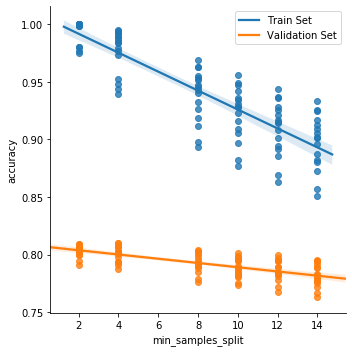

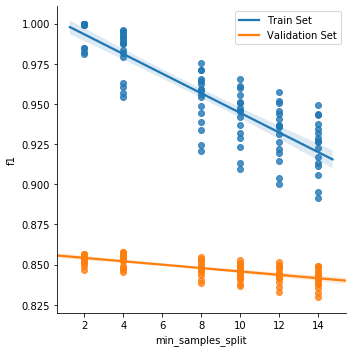

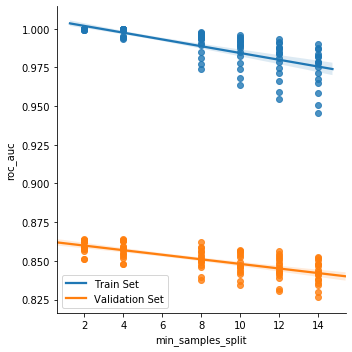

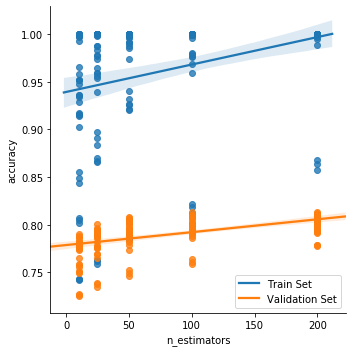

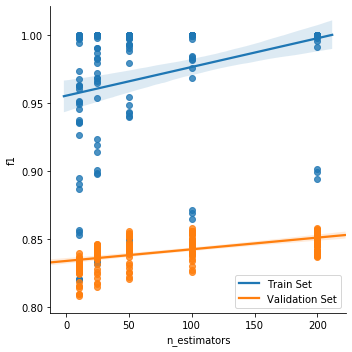

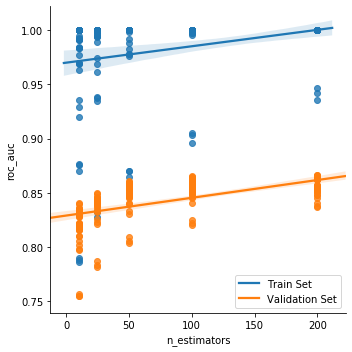

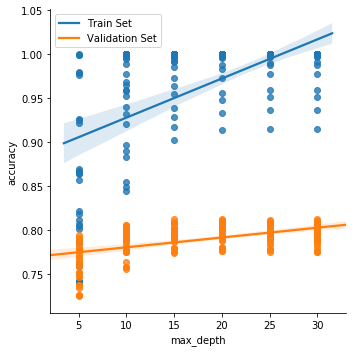

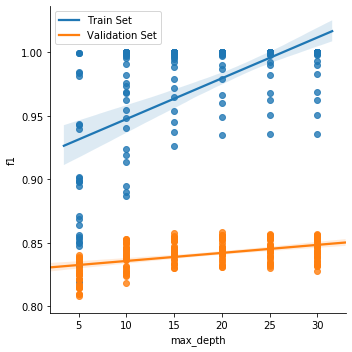

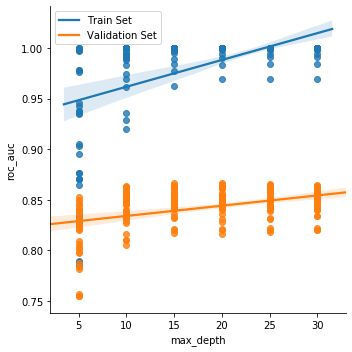

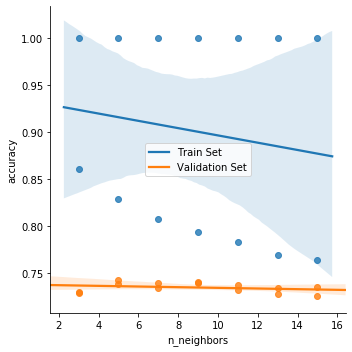

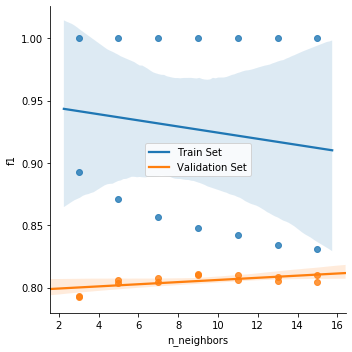

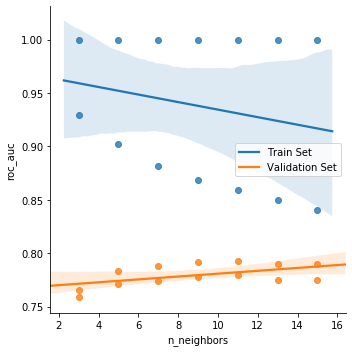

In [80]:
# create metric vs hyper-parameter plots for desired hyper-parameters
params_of_interest = {
    'forest' : ['min_samples_split'],
    'xg' : ['n_estimators', 'max_depth'],
    'knn' : ['n_neighbors']
}

# create parameter metric plots
for k,v in params_of_interest.items():
    for p in v:
        for m in metrics:
            this_df = results[k][[f'param_{k}__{p}', f'mean_train_{m}', f'mean_test_{m}']]  # get a df of the data we want
            this_df[f'param_{k}__{p}'] = this_df[f'param_{k}__{p}'].astype('float')  # convert param to float to plot
            this_df = pd.melt(this_df, id_vars=[f'param_{k}__{p}'])  # create a df that we can use with seaborns hue
            g = sns.lmplot(x=f'param_{k}__{p}', y="value", hue="variable", data=this_df, legend=False)
            g.set(xlabel=p, ylabel=m)
            plt.legend(labels=['Train Set', 'Validation Set'])
            plt.savefig(f'figs/{k}__{p}__{m}.png')
            plt.show()

In [87]:
# print params for the best model of each algorithm
for k,v in results.items():
    print(k)
    print(v.iloc[0]['params'])
    print()

forest
{'forest__criterion': 'entropy', 'forest__max_features': 0.5, 'forest__max_samples': 0.99999999, 'forest__min_samples_split': 4}

xg
{'xg__learning_rate': 0.1, 'xg__max_depth': 20, 'xg__n_estimators': 100, 'xg__reg_lambda': 2}

knn
{'knn__n_neighbors': 5, 'knn__weights': 'distance'}



In [128]:
# collect the metrics from the top performing model for each algorithm for each of the 
# 10 validation sets (from 10-fold cross-validation) and put into a single df to plot easily
top_models_metrics = []
full_alg_names = {'forest': 'Random Forest', 'xg': 'XGBoost', 'knn': 'KNN'}
for k,v in results.items():
    this_df = v.iloc[0][[c for c in v.columns if 'split' in c and 'test' in c]].to_frame(name='value')
    this_df['algorithm'] = full_alg_names[k]
    top_models_metrics.append(this_df)
    
top_models_metrics = pd.concat(top_models_metrics, axis=0)
top_models_metrics = top_models_metrics.reset_index(drop=False)
top_models_metrics = top_models_metrics.rename(columns={'index':'metric'})
top_models_metrics['metric'] = top_models_metrics['metric'].apply(lambda x: x.split('test_')[1])
top_models_metrics

,metric,value,algorithm
0,accuracy,0.81016,Random Forest
1,accuracy,0.80589,Random Forest
2,accuracy,0.804552,Random Forest
3,accuracy,0.820616,Random Forest
4,accuracy,0.825971,Random Forest
...,...,...,...
85,roc_auc,0.776196,KNN
86,roc_auc,0.790975,KNN
87,roc_auc,0.743603,KNN
88,roc_auc,0.792426,KNN


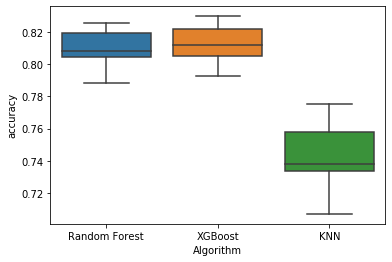

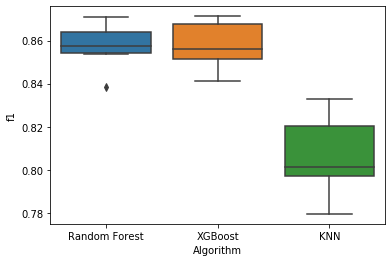

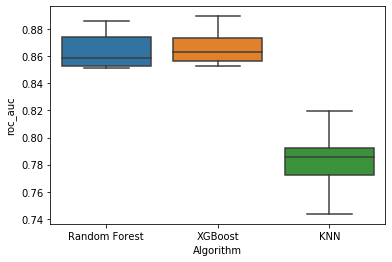

In [130]:
for m in metrics:
    g = sns.boxplot(x="algorithm", y="value", data=top_models_metrics[top_models_metrics['metric'] == m])
    g.set(xlabel='Algorithm', ylabel=m)
    plt.savefig(f'figs/top_models_{m}.png')
    plt.show()

In [142]:
# use pca to reduce test.csv dimensions down to two and plot the predictions for each algorithm's best model
pca = PCA(n_components=2)
reduced_df = CleanUp().transform(X_test)
reduced_df = OneHotEncode().fit(reduced_df, y=None).transform(reduced_df)
reduced_df = pd.DataFrame(pca.fit_transform(reduced_df))
reduced_df = reduced_df.rename(columns={0:'x', 1:'y'})

forest


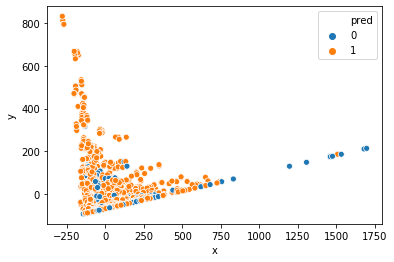

xg


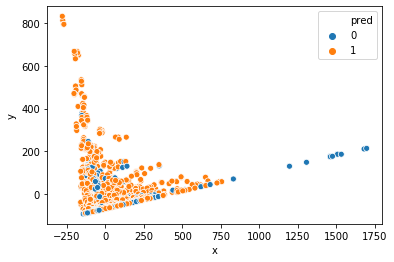

knn


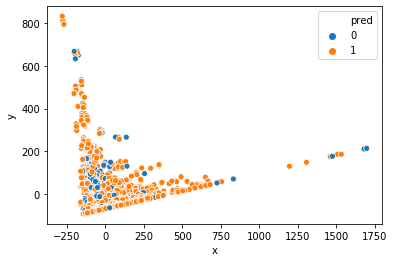

In [145]:
for label, model in {'forest': forest, 'xg': xg, 'knn': knn}.items():
    this_df = reduced_df.copy(deep=True)
    this_df['pred'] = model.predict(X_test)
    g = sns.scatterplot(x='x', y='y', hue='pred', data=this_df)
    print(label)
    plt.savefig(f'figs/{label}_pca_preds.png')
    plt.show()    
    